# Import Library

In [204]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, SimpleRNN, Bidirectional, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath('../'))
from RNN.RNNFromScratch import RNNFromScratch

In [118]:
# Set a random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load Datasets

In [119]:
try:
    train_df = pd.read_csv('../dataset/train.csv')
    valid_df = pd.read_csv('../dataset/valid.csv')
    test_df = pd.read_csv('../dataset/test.csv')
except FileNotFoundError:
    print("Directory invalid!.")
    exit()

X_train, y_train = train_df['text'], train_df['label']
X_val, y_val = valid_df['text'], valid_df['label']
X_test, y_test = test_df['text'], test_df['label']

# Text Vectorization

In [120]:
# TextVectorization
max_features = 5000 
sequence_length = 100 

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

vectorize_layer.adapt(X_train)

In [121]:
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

X_train_vec = vectorize_text(X_train).numpy()
X_val_vec = vectorize_text(X_val).numpy()
X_test_vec = vectorize_text(X_test).numpy()

In [122]:
# Encode labels 
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

y_train_np = np.array(y_train_enc)
y_val_np = np.array(y_val_enc)
y_test_np = np.array(y_test_enc)

print(f"X_train_vec shape: {X_train_vec.shape}")
print(f"y_train_np shape: {y_train_np.shape}")
print(f"X_val_vec shape: {X_val_vec.shape}")
print(f"y_val_np shape: {y_val_np.shape}")
print(f"X_test_vec shape: {X_test_vec.shape}")
print(f"y_test_np shape: {y_test_np.shape}")

vocab_size = len(vectorize_layer.get_vocabulary())
print(f"Vocabulary size: {vocab_size}")

num_classes = len(np.unique(y_train_np))
print(f"Number of classes: {num_classes}")

X_train_vec shape: (500, 100)
y_train_np shape: (500,)
X_val_vec shape: (100, 100)
y_val_np shape: (100,)
X_test_vec shape: (400, 100)
y_test_np shape: (400,)
Vocabulary size: 2836
Number of classes: 3


# Modeling RNN From Keras

In [123]:
class F1Score(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.f1_scores = []
        self.val_f1_scores = []
    
    def on_epoch_end(self, epoch, logs=None):
        # Training F1
        train_pred = self.model.predict(self.validation_data[0], verbose=0)
        train_pred_classes = np.argmax(train_pred, axis=1)
        train_f1 = f1_score(self.validation_data[1], train_pred_classes, average='macro', zero_division=0)
        
        # Validation F1
        val_pred = self.model.predict(self.validation_data[2], verbose=0)
        val_pred_classes = np.argmax(val_pred, axis=1)
        val_f1 = f1_score(self.validation_data[3], val_pred_classes, average='macro', zero_division=0)
        
        self.f1_scores.append(train_f1)
        self.val_f1_scores.append(val_f1)
        
        logs = logs or {}
        logs['f1_macro'] = train_f1
        logs['val_f1_macro'] = val_f1
        
        print(f" - f1_macro: {train_f1:.4f} - val_f1_macro: {val_f1:.4f}")

# Plot history function
def plot_history(history, title, f1_callback=None):
    plt.figure(figsize=(14, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot F1-score
    plt.subplot(1, 2, 2)
    if f1_callback and len(f1_callback.f1_scores) > 0:
        plt.plot(f1_callback.f1_scores, label='Training F1-macro', marker='^')
        plt.plot(f1_callback.val_f1_scores, label='Validation F1-macro', marker='d')
        plt.title(f'{title} - F1-macro Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1-macro Score')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, "F1-macro scores unavailable", 
                horizontalalignment='center', verticalalignment='center', 
                transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()

In [124]:
# Base training parameters
embedding_dim = 256 
epochs = 10
batch_size = 32

In [125]:
# Base model creation function
def create_rnn_model(rnn_layers_config, dropout_rate=0.5): 
    model = Sequential()

    model.add(Embedding(vocab_size, embedding_dim))

    for i, (rnn_layer_type, cells) in enumerate(rnn_layers_config):
        return_sequences = (i < len(rnn_layers_config) - 1)

        if rnn_layer_type == 'simple':
            model.add(SimpleRNN(cells, return_sequences=return_sequences))
        elif rnn_layer_type == 'bidirectional_simple': 
            model.add(Bidirectional(SimpleRNN(cells, return_sequences=return_sequences)))

        model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))

    model.build(input_shape=(None, sequence_length))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss=SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
    return model

# Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)


# 1. Pengaruh Jumlah Layer RNN


Training with 1 Bidirectional SimpleRNN layer(s)...


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_93 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_159               │ (None, 128)            │        41,088 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 767,491 (2.93 MB)

 Trainable params: 767,491 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3934 - loss: 1.1144 - f1_macro: 0.7182 - val_f1_macro: 0.4460
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.3937 - loss: 1.1134 - val_accuracy: 0.5300 - val_loss: 0.9965 - f1_macro: 0.7182 - val_f1_macro: 0.4460
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6735 - loss: 0.7826 - f1_macro: 0.9347 - val_f1_macro: 0.3983
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6745 - loss: 0.7823 - val_accuracy: 0.4500 - val_loss: 0.9986 - f1_macro: 0.9347 - val_f1_macro: 0.3983
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9379 - loss: 0.4623 - f1_macro: 0.9751 - val_f1_macro: 0.4179
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9376 - loss: 0.4615 - val_accuracy: 0.4200 - val_loss: 0.9952 - f1_macro: 0.9751 - val_f1_macro: 0.4179
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9783 - loss: 0.2260 - f1_macro: 0.9932 - val_f1_macro: 0.4738
16/16 ━━━━━━━━━

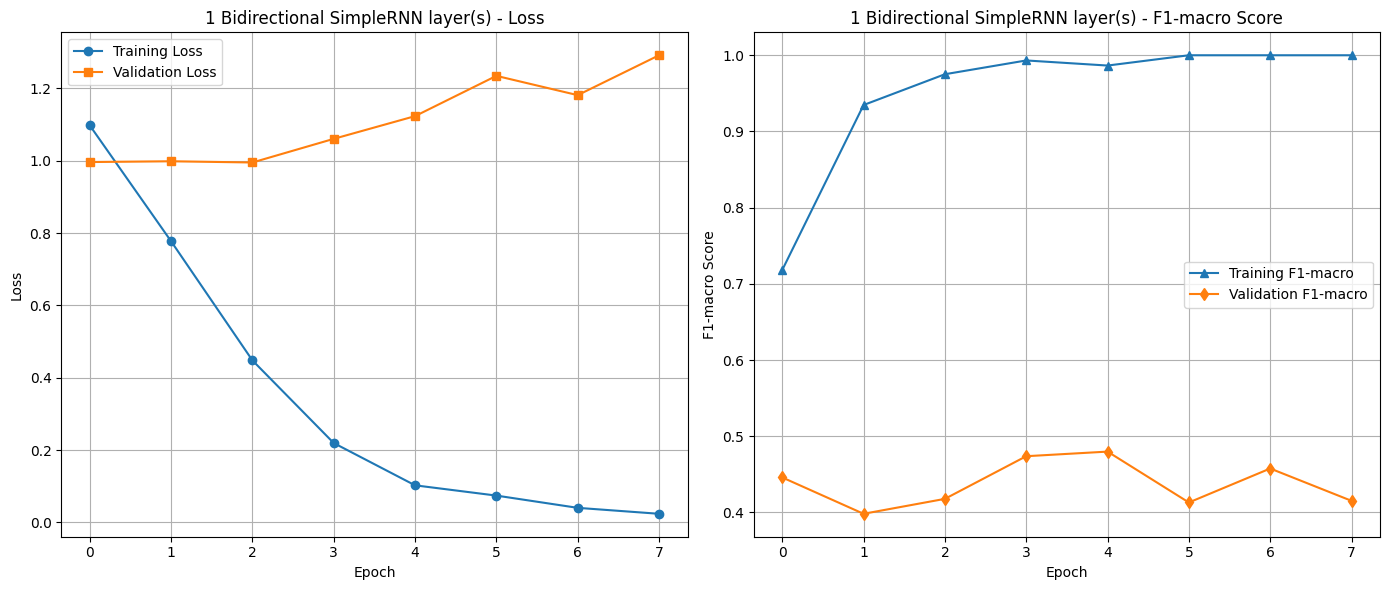


Training with 2 Bidirectional SimpleRNN layer(s)...


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_94 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_160               │ (None, 100, 128)       │        41,088 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_161               │ (None, 128)            │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 792,195 (3.02 MB)

 Trainable params: 792,195 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3108 - loss: 1.3000 - f1_macro: 0.4542 - val_f1_macro: 0.3957
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.3125 - loss: 1.2985 - val_accuracy: 0.5200 - val_loss: 0.9752 - f1_macro: 0.4542 - val_f1_macro: 0.3957
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5727 - loss: 0.9062 - f1_macro: 0.5462 - val_f1_macro: 0.4135
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.5725 - loss: 0.9063 - val_accuracy: 0.5500 - val_loss: 0.9733 - f1_macro: 0.5462 - val_f1_macro: 0.4135
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7713 - loss: 0.6146 - f1_macro: 0.9279 - val_f1_macro: 0.5469
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7726 - loss: 0.6117 - val_accuracy: 0.5700 - val_loss: 0.8805 - f1_macro: 0.9279 - val_f1_macro: 0.5469
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8776 - loss: 0.3564 - f1_macro: 0.9910 - val_f1_macro: 0.5396
16/16 ━━━━━━━━

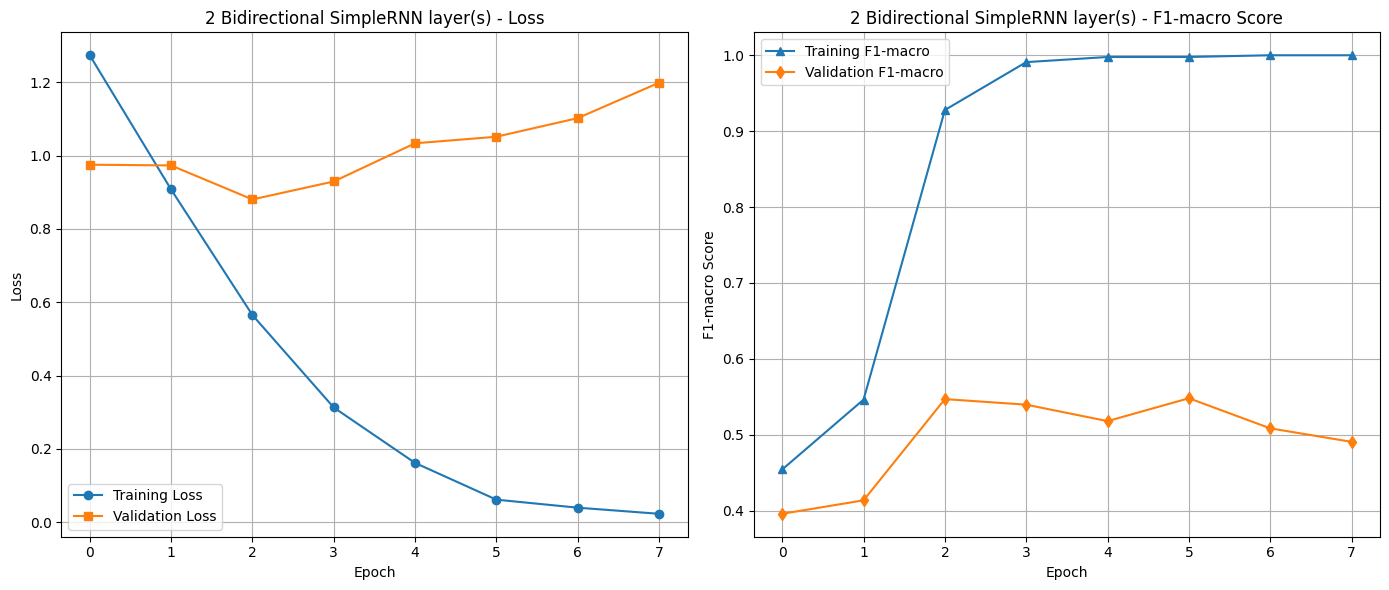


Training with 3 Bidirectional SimpleRNN layer(s)...


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_95 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_162               │ (None, 100, 128)       │        41,088 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_163               │ (None, 100, 128)       │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_164               │ (None, 128)            │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 816,899 (3.12 MB)

 Trainable params: 816,899 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3643 - loss: 1.4245 - f1_macro: 0.3978 - val_f1_macro: 0.3801
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.3651 - loss: 1.4222 - val_accuracy: 0.5100 - val_loss: 1.1394 - f1_macro: 0.3978 - val_f1_macro: 0.3801
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4334 - loss: 1.2581 - f1_macro: 0.4868 - val_f1_macro: 0.4258
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.4339 - loss: 1.2584 - val_accuracy: 0.5600 - val_loss: 1.1107 - f1_macro: 0.4868 - val_f1_macro: 0.4258
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5664 - loss: 0.9715 - f1_macro: 0.7439 - val_f1_macro: 0.4434
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.5664 - loss: 0.9701 - val_accuracy: 0.5500 - val_loss: 0.9788 - f1_macro: 0.7439 - val_f1_macro: 0.4434
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6579 - loss: 0.7376 - f1_macro: 0.9331 - val_f1_macro: 0.4790
16/16 ━━━━━

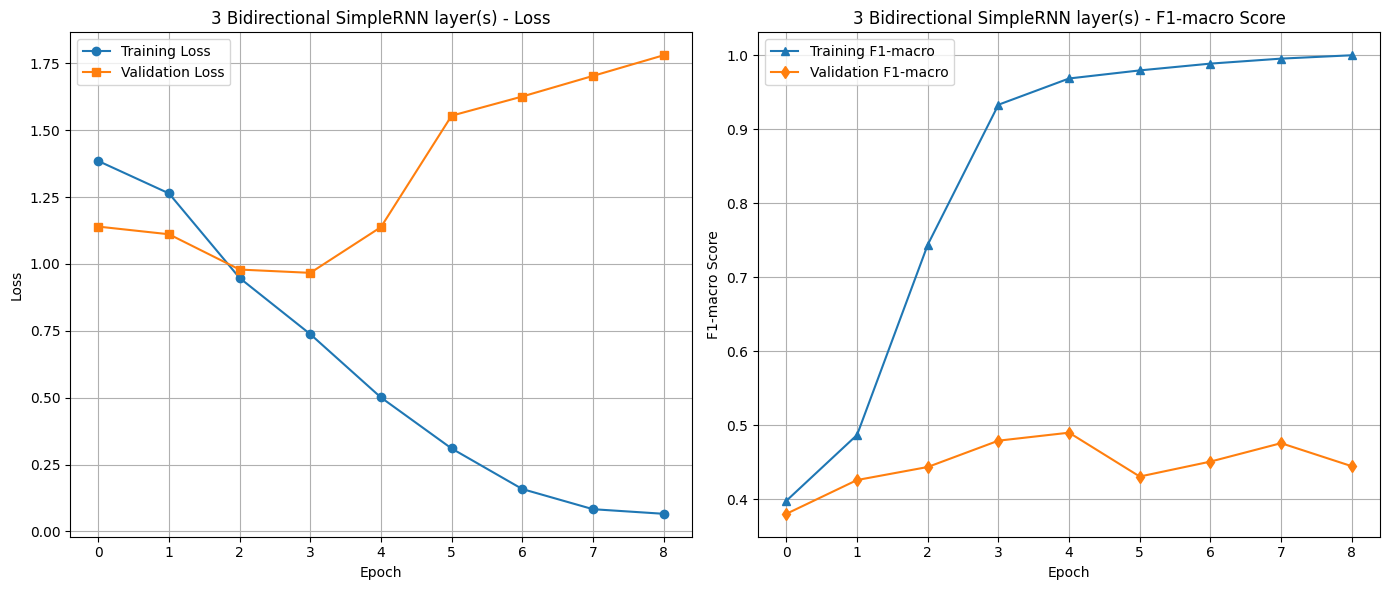


Comparison of Number of RNN Layers:
Model: num_layers_1_bidirectional_simple, Macro F1-score: 0.4920
Model: num_layers_2_bidirectional_simple, Macro F1-score: 0.5551
Model: num_layers_3_bidirectional_simple, Macro F1-score: 0.5571


In [56]:
rnn_layer_configs_num_layers = [
    [('bidirectional_simple', 64)],
    [('bidirectional_simple', 64), ('bidirectional_simple', 64)],
    [('bidirectional_simple', 64), ('bidirectional_simple', 64), ('bidirectional_simple', 64)],
]

histories_num_layers = {}
f1_scores_num_layers = {}
f1_callbacks_num_layers = {}

for i, config in enumerate(rnn_layer_configs_num_layers):
    num_layers_str = f"{len(config)} {'Bidirectional SimpleRNN' if config[0][0].startswith('bidirectional') else 'SimpleRNN'} layer(s)"
    print(f"\nTraining with {num_layers_str}...")

    model_name = f"num_layers_{len(config)}_{config[0][0]}"
    model = create_rnn_model(config)
    model.summary()

    f1_callback = F1Score((X_train_vec, y_train_np, X_val_vec, y_val_np))

    history = model.fit(X_train_vec, y_train_np,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_val_vec, y_val_np),
                       callbacks=[early_stopping, f1_callback],
                       verbose=1)
    
    histories_num_layers[model_name] = history
    f1_callbacks_num_layers[model_name] = f1_callback

    y_pred_probs = model.predict(X_test_vec)
    y_pred = np.argmax(y_pred_probs, axis=1)
    macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
    f1_scores_num_layers[model_name] = macro_f1

    print(f"Macro F1-score for {num_layers_str}: {macro_f1:.4f}")
    plot_history(history, f"{num_layers_str}", f1_callback)

print("\nComparison of Number of RNN Layers:")
for name, f1 in f1_scores_num_layers.items():
    print(f"Model: {name}, Macro F1-score: {f1:.4f}")

# 2. Pengaruh Banyak Cell RNN per Layer


Training with Bidirectional SimpleRNN with 32 cells...


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_96 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_165               │ (None, 64)             │        18,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 744,707 (2.84 MB)

 Trainable params: 744,707 (2.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3552 - loss: 1.1112 - f1_macro: 0.6350 - val_f1_macro: 0.3484
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.3598 - loss: 1.1078 - val_accuracy: 0.4700 - val_loss: 1.0423 - f1_macro: 0.6350 - val_f1_macro: 0.3484
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7914 - loss: 0.7644 - f1_macro: 0.9637 - val_f1_macro: 0.4755
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.7908 - loss: 0.7639 - val_accuracy: 0.5300 - val_loss: 0.9524 - f1_macro: 0.9637 - val_f1_macro: 0.4755
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9227 - loss: 0.5038 - f1_macro: 0.9785 - val_f1_macro: 0.5415
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9234 - loss: 0.5011 - val_accuracy: 0.5500 - val_loss: 0.9281 - f1_macro: 0.9785 - val_f1_macro: 0.5415
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9727 - loss: 0.2909 - f1_macro: 0.9960 - val_f1_macro: 0.5385
16/16 ━━━━━━━━━

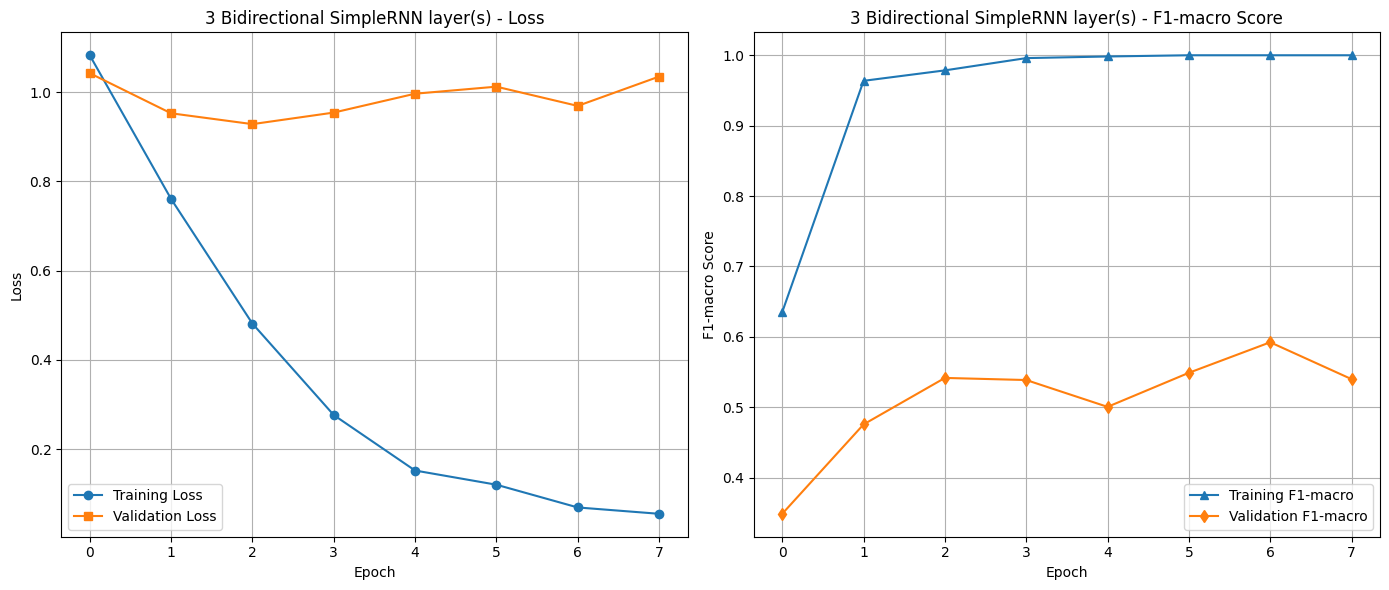


Training with Bidirectional SimpleRNN with 64 cells...


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_97 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_166               │ (None, 128)            │        41,088 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 767,491 (2.93 MB)

 Trainable params: 767,491 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3386 - loss: 1.1345 - f1_macro: 0.6211 - val_f1_macro: 0.3800
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.3402 - loss: 1.1312 - val_accuracy: 0.5000 - val_loss: 0.9929 - f1_macro: 0.6211 - val_f1_macro: 0.3800
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7197 - loss: 0.7732 - f1_macro: 0.9275 - val_f1_macro: 0.4356
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7185 - loss: 0.7742 - val_accuracy: 0.4800 - val_loss: 0.9987 - f1_macro: 0.9275 - val_f1_macro: 0.4356
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9414 - loss: 0.4617 - f1_macro: 0.9884 - val_f1_macro: 0.4889
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9407 - loss: 0.4610 - val_accuracy: 0.5500 - val_loss: 0.9536 - f1_macro: 0.9884 - val_f1_macro: 0.4889
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9804 - loss: 0.2161 - f1_macro: 0.9937 - val_f1_macro: 0.4562
16/16 ━━━━━━━━━

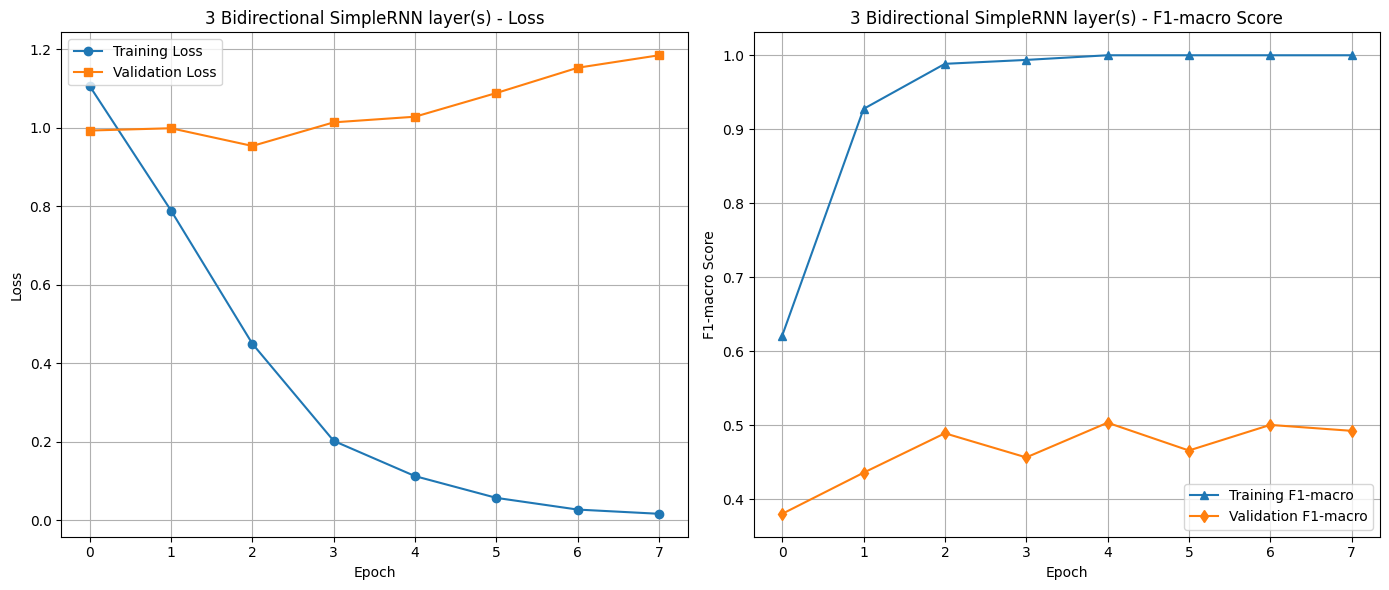


Training with Bidirectional SimpleRNN with 128 cells...


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_98 (Embedding)        │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_167               │ (None, 256)            │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,347 (3.15 MB)

 Trainable params: 825,347 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3542 - loss: 1.0791 - f1_macro: 0.6356 - val_f1_macro: 0.4827
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.3574 - loss: 1.0769 - val_accuracy: 0.5300 - val_loss: 1.0195 - f1_macro: 0.6356 - val_f1_macro: 0.4827
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6914 - loss: 0.7096 - f1_macro: 0.9241 - val_f1_macro: 0.4421
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.6932 - loss: 0.7093 - val_accuracy: 0.5500 - val_loss: 0.9528 - f1_macro: 0.9241 - val_f1_macro: 0.4421
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8872 - loss: 0.4349 - f1_macro: 0.9471 - val_f1_macro: 0.5114
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.8856 - loss: 0.4363 - val_accuracy: 0.5600 - val_loss: 0.9622 - f1_macro: 0.9471 - val_f1_macro: 0.5114
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9595 - loss: 0.2548 - f1_macro: 0.9829 - val_f1_macro: 0.4826
16/16 ━━━━━━━━━

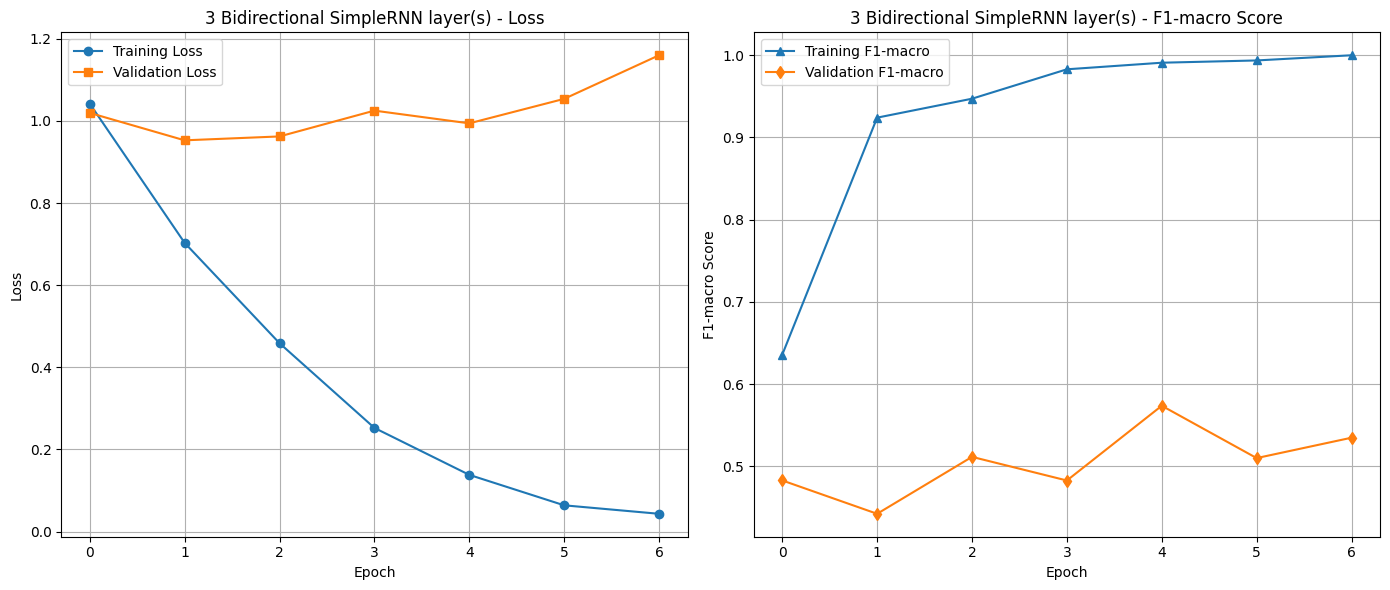


Comparison of Number of RNN Cells per Layer:
Model: num_cells_32, Macro F1-score: 0.5640
Model: num_cells_64, Macro F1-score: 0.5052
Model: num_cells_128, Macro F1-score: 0.4158


In [57]:
rnn_layer_configs_num_cells = [
    [('bidirectional_simple', 32)], 
    [('bidirectional_simple', 64)], 
    [('bidirectional_simple', 128)], 
]

histories_num_cells = {}
f1_scores_num_cells = {}
f1_callbacks_num_cells = {} 

for i, config in enumerate(rnn_layer_configs_num_cells):
    num_cells_str = f"Bidirectional SimpleRNN with {config[0][1]} cells"
    print(f"\nTraining with {num_cells_str}...")

    model_name = f"num_cells_{config[0][1]}"
    model = create_rnn_model(config)
    model.summary()

    f1_callback = F1Score((X_train_vec, y_train_np, X_val_vec, y_val_np))

    history = model.fit(X_train_vec, y_train_np,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_val_vec, y_val_np),
                       callbacks=[early_stopping, f1_callback], 
                       verbose=1)
    
    histories_num_cells[model_name] = history
    f1_callbacks_num_cells[model_name] = f1_callback 
    
    y_pred_probs = model.predict(X_test_vec)
    y_pred = np.argmax(y_pred_probs, axis=1)
    macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
    f1_scores_num_cells[model_name] = macro_f1

    print(f"Macro F1-score for {num_cells_str}: {macro_f1:.4f}")
    plot_history(history, f"{num_layers_str}", f1_callback)

print("\nComparison of Number of RNN Cells per Layer:")
for name, f1 in f1_scores_num_cells.items():
    print(f"Model: {name}, Macro F1-score: {f1:.4f}")

# 3. Pengaruh Jenis Layer RNN Berdasarkan Arah


Training with Unidirectional SimpleRNN...


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_105 (Embedding)       │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_182 (SimpleRNN)      │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,683 (2.96 MB)

 Trainable params: 775,683 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4067 - loss: 1.0759 - f1_macro: 0.4894 - val_f1_macro: 0.4999
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.4078 - loss: 1.0759 - val_accuracy: 0.5000 - val_loss: 0.9979 - f1_macro: 0.4894 - val_f1_macro: 0.4999
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4542 - loss: 1.0570 - f1_macro: 0.5032 - val_f1_macro: 0.2980
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4584 - loss: 1.0555 - val_accuracy: 0.3900 - val_loss: 1.0789 - f1_macro: 0.5032 - val_f1_macro: 0.2980
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4563 - loss: 1.0814 - f1_macro: 0.2267 - val_f1_macro: 0.2612
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4471 - loss: 1.0963 - val_accuracy: 0.3900 - val_loss: 1.1557 - f1_macro: 0.2267 - val_f1_macro: 0.2612
Epoch 4/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4276 - loss: 1.0640 - f1_macro: 0.3950 - val_f1_macro: 0.4097
16/16 ━━━━━━━━━━━━

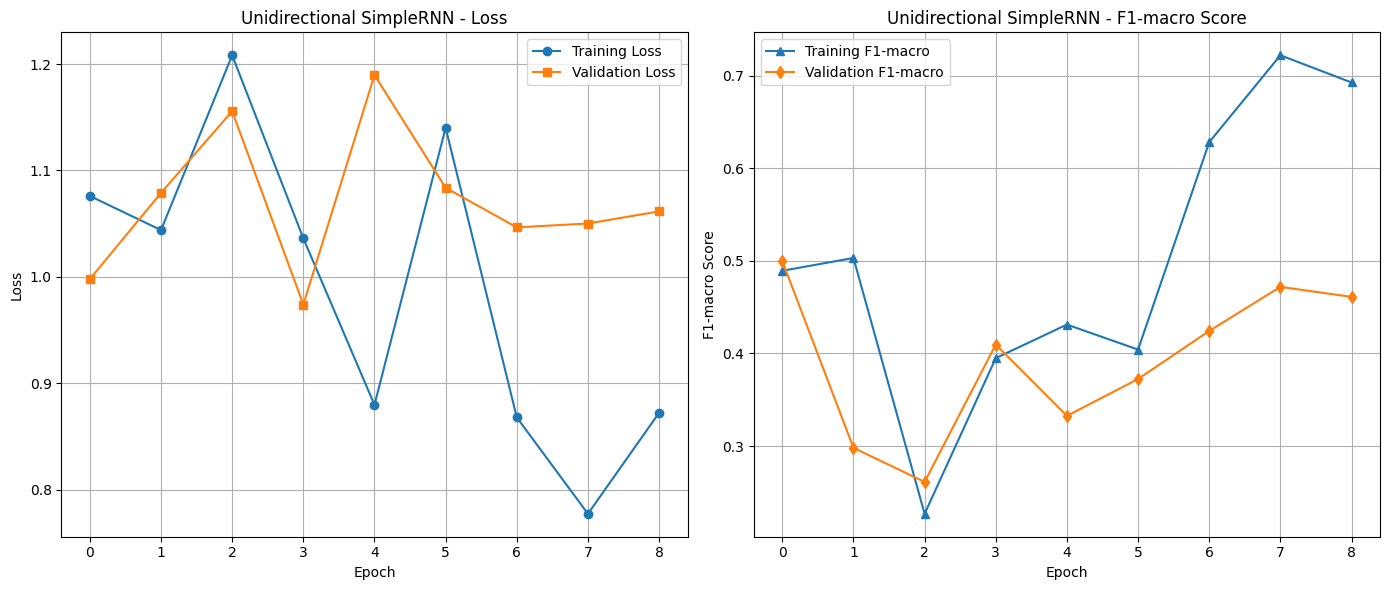


Training with Bidirectional SimpleRNN...


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_106 (Embedding)       │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_171               │ (None, 256)            │        98,560 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,347 (3.15 MB)

 Trainable params: 825,347 (3.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3780 - loss: 1.0986 - f1_macro: 0.7160 - val_f1_macro: 0.4557
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.3824 - loss: 1.0944 - val_accuracy: 0.5300 - val_loss: 0.9848 - f1_macro: 0.7160 - val_f1_macro: 0.4557
Epoch 2/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6847 - loss: 0.7788 - f1_macro: 0.9387 - val_f1_macro: 0.4707
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6884 - loss: 0.7789 - val_accuracy: 0.5100 - val_loss: 0.9437 - f1_macro: 0.9387 - val_f1_macro: 0.4707
Epoch 3/10
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8975 - loss: 0.4487 - f1_macro: 0.9829 - val_f1_macro: 0.4694
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8988 - loss: 0.4456 - val_accuracy: 0.4800 - val_loss: 1.0265 - f1_macro: 0.9829 - val_f1_macro: 0.4694
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9746 - loss: 0.1876 - f1_macro: 0.9798 - val_f1_macro: 0.4637
16/16 ━━━━━━━━━━━

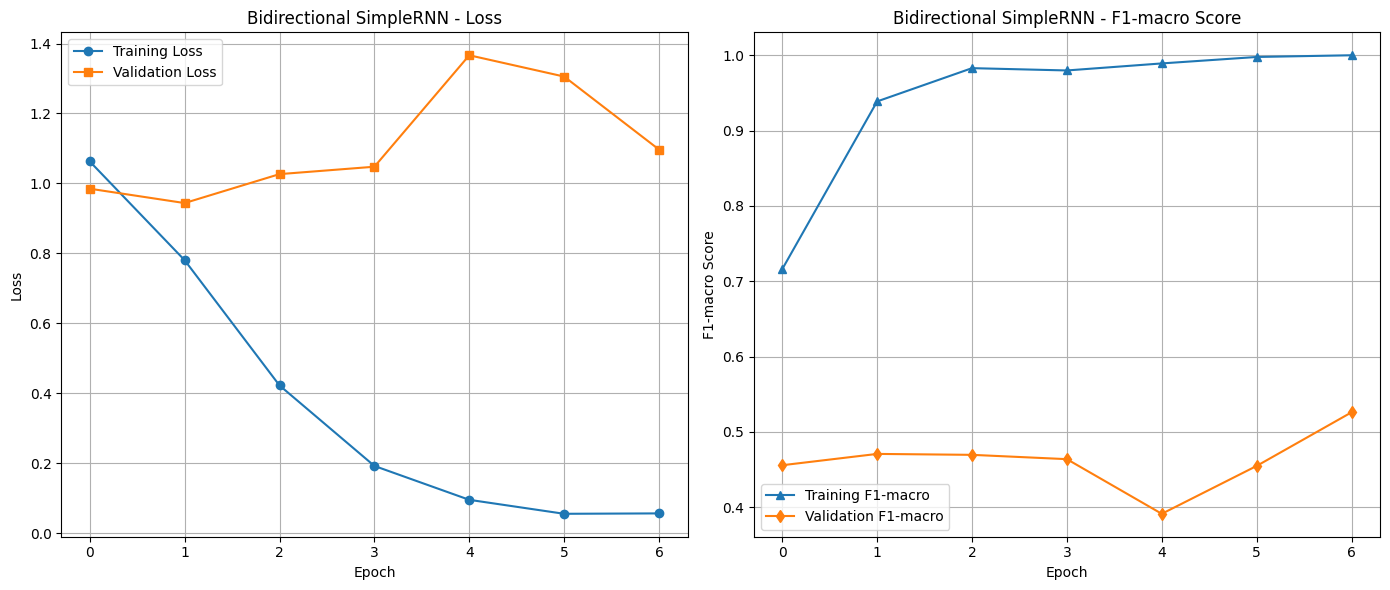


Comparison of RNN Layer Direction:
Model: direction_simple, Macro F1-score: 0.3770
Model: direction_bidirectional_simple, Macro F1-score: 0.5701


In [61]:
rnn_layer_configs_direction = [
    [('simple', 128)],             
    [('bidirectional_simple', 128)], 
]

histories_direction = {}
f1_scores_direction = {}
f1_callbacks_direction = {} 

for i, config in enumerate(rnn_layer_configs_direction):
    direction_type_str = "Unidirectional SimpleRNN" if config[0][0] == 'simple' else "Bidirectional SimpleRNN"
    print(f"\nTraining with {direction_type_str}...")

    model_name = f"direction_{config[0][0]}"
    model = create_rnn_model(config)
    model.summary()

    f1_callback = F1Score((X_train_vec, y_train_np, X_val_vec, y_val_np))

    history = model.fit(X_train_vec, y_train_np,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_val_vec, y_val_np),
                       callbacks=[early_stopping, f1_callback], 
                       verbose=1)
    
    histories_direction[model_name] = history
    f1_callbacks_direction[model_name] = f1_callback  
    
    y_pred_probs = model.predict(X_test_vec)
    y_pred = np.argmax(y_pred_probs, axis=1)
    macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
    f1_scores_direction[model_name] = macro_f1
    
    print(f"Macro F1-score for {direction_type_str}: {macro_f1:.4f}")
    plot_history(history, f"{direction_type_str}", f1_callback)

print("\nComparison of RNN Layer Direction:")
for name, f1 in f1_scores_direction.items():
    print(f"Model: {name}, Macro F1-score: {f1:.4f}")

# 4. Forward Propagation: Keras Vs From Scratch

In [159]:
# Create final model
final_config = [('simple', 128), ('bidirectional_simple', 64), ('bidirectional_simple', 64)]
final_model = create_rnn_model(final_config)

final_model.summary()

# Train final model
print("\nTraining Final Model...")
final_f1_callback = F1Score((X_train_vec, y_train_np, X_val_vec, y_val_np))

final_history = final_model.fit(X_train_vec, y_train_np,
                               epochs=epochs,
                               batch_size=batch_size,
                               validation_data=(X_val_vec, y_val_np),
                               callbacks=[early_stopping, final_f1_callback],
                               verbose=1)

# Evaluate final model
y_pred_probs = final_model.predict(X_test_vec)
y_pred = np.argmax(y_pred_probs, axis=1)
final_macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
print(f"\nFinal Model Macro F1-score: {final_macro_f1:.4f}")

Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_167 (Embedding)       │ (None, 100, 256)       │       726,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_372 (SimpleRNN)      │ (None, 100, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_372 (Dropout)           │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_260               │ (None, 100, 128)       │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_373 (Dropout)           │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_261               │ (None, 128)            │        24,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_374 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 825,091 (3.15 MB)

 Trainable params: 825,091 (3.15 MB)

 Non-trainable params: 0 (0.00 B)


Training Final Model...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3592 - loss: 1.3475 - f1_macro: 0.3744 - val_f1_macro: 0.2085
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 497ms/step - accuracy: 0.3597 - loss: 1.3490 - val_accuracy: 0.3200 - val_loss: 1.2079 - f1_macro: 0.3744 - val_f1_macro: 0.2085
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4048 - loss: 1.2310 - f1_macro: 0.4606 - val_f1_macro: 0.3681
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.4055 - loss: 1.2305 - val_accuracy: 0.3900 - val_loss: 1.1116 - f1_macro: 0.4606 - val_f1_macro: 0.3681
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5864 - loss: 0.9499 - f1_macro: 0.7158 - val_f1_macro: 0.5154
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.5864 - loss: 0.9509 - val_accuracy: 0.5600 - val_loss: 1.1152 - f1_macro: 0.7158 - val_f1_macro: 0.5154
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6716 - loss: 0.7610 - f1_macro: 0.8840 - val_f1

In [160]:
print("\nSaving Model...")
final_model.save('output_model/rnn_model.h5')
print("Model saved successfully!")


Saving Model...
Model saved successfully!


In [161]:
try:
    loaded_keras_model = tf.keras.models.load_model('output_model/rnn_model.h5')
    print("✓ Keras model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Using the current final_model instead...")
    loaded_keras_model = final_model

✓ Keras model loaded successfully!


In [162]:
# Initialize from scratch model
rnn_scratch = RNNFromScratch()
rnn_scratch.load_keras_model(loaded_keras_model)


Loading Keras model into RNNFromScratch...

Processing layer 1: Embedding
Added EmbeddingLayer: vocab_size=2836, embedding_dim=256

Processing layer 2: SimpleRNN
Added SimpleRNNLayer: units=128, return_sequences=True

Processing layer 3: Dropout
Added DropoutLayer: rate=0.5

Processing layer 4: Bidirectional
Added BidirectionalRNNLayer: units=128, return_sequences=True

Processing layer 5: Dropout
Added DropoutLayer: rate=0.5

Processing layer 6: Bidirectional
Added BidirectionalRNNLayer: units=128, return_sequences=False

Processing layer 7: Dropout
Added DropoutLayer: rate=0.5

Processing layer 8: Dense
Added DenseLayer: units=3, activation=softmax

Model loaded successfully!
Total layers: 8
Layer 1: EmbeddingLayer
Layer 2: SimpleRNNLayer
Layer 3: DropoutLayer
Layer 4: BidirectionalRNNLayer
Layer 5: DropoutLayer
Layer 6: BidirectionalRNNLayer
Layer 7: DropoutLayer
Layer 8: DenseLayer


In [163]:
print("\n" + "="*50)
print("FORWARD PROPAGATION: KERAS VS FROM SCRATCH MODELS")
print("="*50)

# Get predictions from both models
print("Getting Keras model predictions...")
try:
    keras_pred_probs_full = loaded_keras_model.predict(X_test_vec, verbose=0)
    keras_pred_full = np.argmax(keras_pred_probs_full, axis=1)
    keras_f1_full = f1_score(y_test_np, keras_pred_full, average='macro', zero_division=0)
    print(f"✓ Keras predictions obtained successfully")
except Exception as e:
    print(f"Error getting Keras predictions: {e}")
    keras_f1_full = 0
    keras_pred_full = np.zeros_like(y_test_np)
    keras_pred_probs_full = np.zeros((len(y_test_np), num_classes))

print("Getting from-scratch model predictions...")
try:
    scratch_pred_probs_full = rnn_scratch.predict(X_test_vec, batch_size=32)
    scratch_pred_full = np.argmax(scratch_pred_probs_full, axis=1)
    scratch_f1_full = f1_score(y_test_np, scratch_pred_full, average='macro', zero_division=0)
    print(f"✓ From-scratch predictions obtained successfully")
except Exception as e:
    print(f"Error getting from-scratch predictions: {e}")
    print("Creating dummy predictions for comparison...")
    scratch_f1_full = 0
    scratch_pred_full = np.zeros_like(y_test_np)
    scratch_pred_probs_full = np.zeros((len(y_test_np), num_classes))


FORWARD PROPAGATION: KERAS VS FROM SCRATCH MODELS
Getting Keras model predictions...
✓ Keras predictions obtained successfully
Getting from-scratch model predictions...
✓ From-scratch predictions obtained successfully


In [164]:
# Results comparison
print(f"\nFull Test Set Results:")
print(f"Keras F1-score: {keras_f1_full:.6f}")
print(f"From Scratch F1-score: {scratch_f1_full:.6f}")
print(f"\nDifference: {abs(keras_f1_full - scratch_f1_full):.6f}")

if keras_pred_probs_full.size > 0 and scratch_pred_probs_full.size > 0:
    prob_diff_full = np.mean(np.abs(keras_pred_probs_full - scratch_pred_probs_full))
    print(f"Average probability difference: {prob_diff_full:.6f}")
    
    # Prediction match rate
    prediction_match = np.mean(keras_pred_full == scratch_pred_full)
    print(f"Prediction match rate: {prediction_match:.6f}")
else:
    prob_diff_full = float('inf')
    prediction_match = 0.0
    print(f"Could not compare probabilities due to errors")


Full Test Set Results:
Keras F1-score: 0.610476
From Scratch F1-score: 0.610476

Difference: 0.000000
Average probability difference: 0.000000
Prediction match rate: 1.000000


# 5. Keras Vs From Scratch Model

In [191]:
rnn_final_scratch = RNNFromScratch(learning_rate=0.001)

rnn_final_scratch.add_embedding_layer(vocab_size, embedding_dim)

rnn_final_scratch.add_simple_rnn_layer(units=128, return_sequences=True)
rnn_final_scratch.add_dropout_layer(0.5)

rnn_final_scratch.add_simple_rnn_layer(units=128, return_sequences=True)
rnn_final_scratch.add_dropout_layer(0.5)

rnn_final_scratch.add_bidirectional_rnn_layer(units=64, return_sequences=False) 
rnn_final_scratch.add_dropout_layer(0.5)

rnn_final_scratch.add_dense_layer(units=num_classes, activation='softmax')


In [192]:
print("\nTraining Final Scratch Model...")
final_scratch_history = rnn_final_scratch.fit(
    X_train_vec, y_train_np,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_vec, y_val_np),
    verbose=1
)


Training Final Scratch Model...
Epoch 1/10 - loss: 1.4978 - f1: 0.3248 - val_loss: 1.4763 - val_f1: 0.2140
Epoch 2/10 - loss: 1.4918 - f1: 0.3211 - val_loss: 1.1257 - val_f1: 0.2071
Epoch 3/10 - loss: 1.4054 - f1: 0.3167 - val_loss: 1.1260 - val_f1: 0.2664
Epoch 4/10 - loss: 1.3444 - f1: 0.3160 - val_loss: 1.1198 - val_f1: 0.2796
Epoch 5/10 - loss: 1.3634 - f1: 0.3200 - val_loss: 1.1580 - val_f1: 0.2020
Epoch 6/10 - loss: 1.3282 - f1: 0.3816 - val_loss: 1.2749 - val_f1: 0.2863
Epoch 7/10 - loss: 1.4157 - f1: 0.2950 - val_loss: 1.1066 - val_f1: 0.2556
Epoch 8/10 - loss: 1.4174 - f1: 0.3184 - val_loss: 1.1073 - val_f1: 0.2723
Epoch 9/10 - loss: 1.3157 - f1: 0.3610 - val_loss: 1.0937 - val_f1: 0.2674
Epoch 10/10 - loss: 1.3980 - f1: 0.3292 - val_loss: 1.0986 - val_f1: 0.3229


In [197]:
scratch_preds = rnn_final_scratch.predict(X_test_vec)
scratch_preds_argmax = np.argmax(scratch_preds, axis=1)
scratch_macro_f1 = f1_score(y_test_np, scratch_preds_argmax, average='macro', zero_division=0)
print(f"\nFinal Scratch Model Macro F1-score: {scratch_macro_f1:.4f}")


Final Scratch Model Macro F1-score: 0.3556


In [198]:
print("\n=== FINAL COMPARISON ===")
print(f"Keras Final Model Macro F1 : {final_macro_f1:.4f}")
print(f"Scratch Final Model Macro F1 : {scratch_macro_f1:.4f}")



=== FINAL COMPARISON ===
Keras Final Model Macro F1 : 0.6105
Scratch Final Model Macro F1 : 0.3556



Plotting Final Keras Model History...


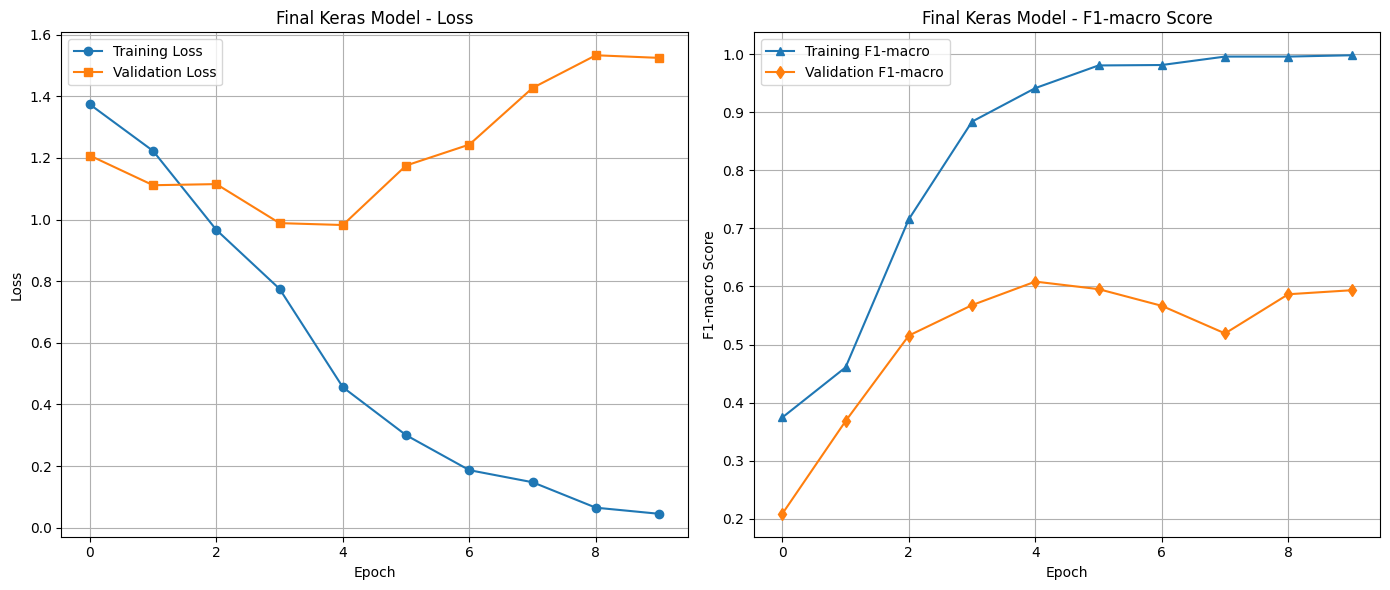

In [199]:
print("\nPlotting Final Keras Model History...")
plot_history(final_history, "Final Keras Model", final_f1_callback)


Plotting Final Scratch Model History...


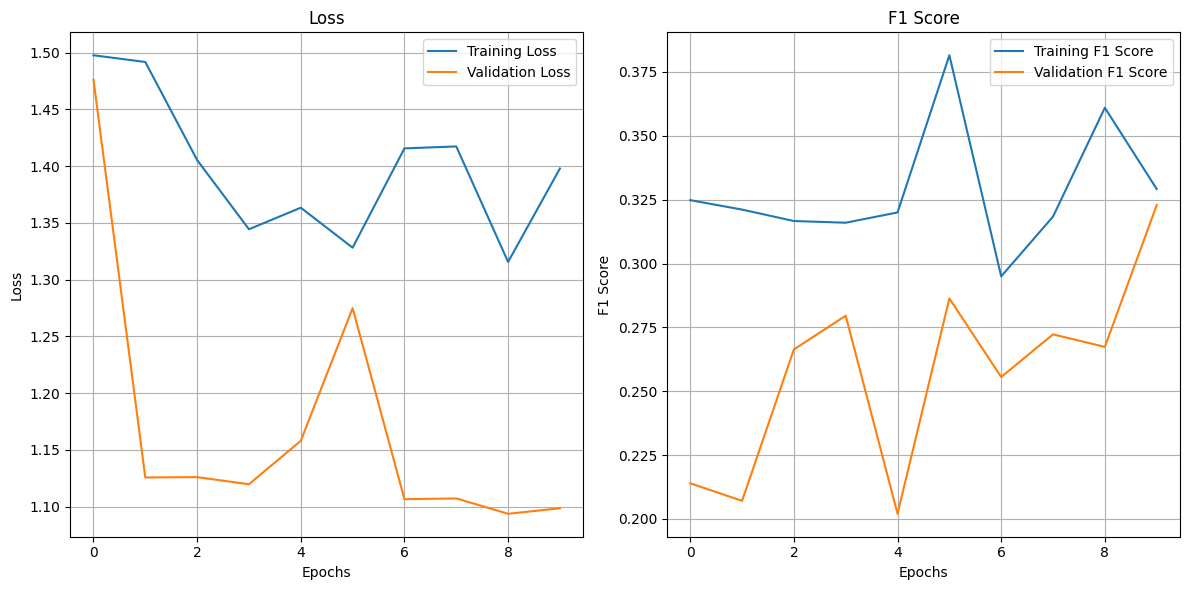

In [200]:
print("\nPlotting Final Scratch Model History...")
rnn_final_scratch.plot_history(final_scratch_history)

In [202]:
print("\n=== DETAILED CLASSIFICATION REPORTS ===")
print("Getting final predictions for classification reports...")

if 'keras_pred_full' not in locals():
    keras_pred_full = np.argmax(loaded_keras_model.predict(X_test_vec, verbose=0), axis=1)

if 'scratch_pred_full' not in locals():
    scratch_pred_full = np.argmax(rnn_scratch.predict(X_test_vec, batch_size=32), axis=1)

print("\nKeras Model Classification Report:")
try:
    print(classification_report(y_test_np, keras_pred_full, 
                              target_names=['Negative', 'Neutral', 'Positive']))
except Exception as e:
    print(f"Error generating Keras classification report: {e}")
    print("Using final model predictions...")
    keras_pred_final = np.argmax(final_model.predict(X_test_vec, verbose=0), axis=1)
    print(classification_report(y_test_np, keras_pred_final, 
                              target_names=['Negative', 'Neutral', 'Positive']))

print("\nFrom-scratch Model Classification Report:")
try:
    print(classification_report(y_test_np, scratch_pred_full, 
                              target_names=['Negative', 'Neutral', 'Positive']))
except Exception as e:
    print(f"Error generating from-scratch classification report: {e}")
    print("Using trained scratch model predictions...")
    print(classification_report(y_test_np, scratch_preds_argmax, 
                              target_names=['Negative', 'Neutral', 'Positive']))


=== DETAILED CLASSIFICATION REPORTS ===
Getting final predictions for classification reports...

Keras Model Classification Report:
              precision    recall  f1-score   support

    Negative       0.56      0.59      0.57       153
     Neutral       0.49      0.66      0.56        96
    Positive       0.83      0.60      0.70       151

    accuracy                           0.61       400
   macro avg       0.63      0.62      0.61       400
weighted avg       0.64      0.61      0.62       400


From-scratch Model Classification Report:
              precision    recall  f1-score   support

    Negative       0.56      0.59      0.57       153
     Neutral       0.49      0.66      0.56        96
    Positive       0.83      0.60      0.70       151

    accuracy                           0.61       400
   macro avg       0.63      0.62      0.61       400
weighted avg       0.64      0.61      0.62       400



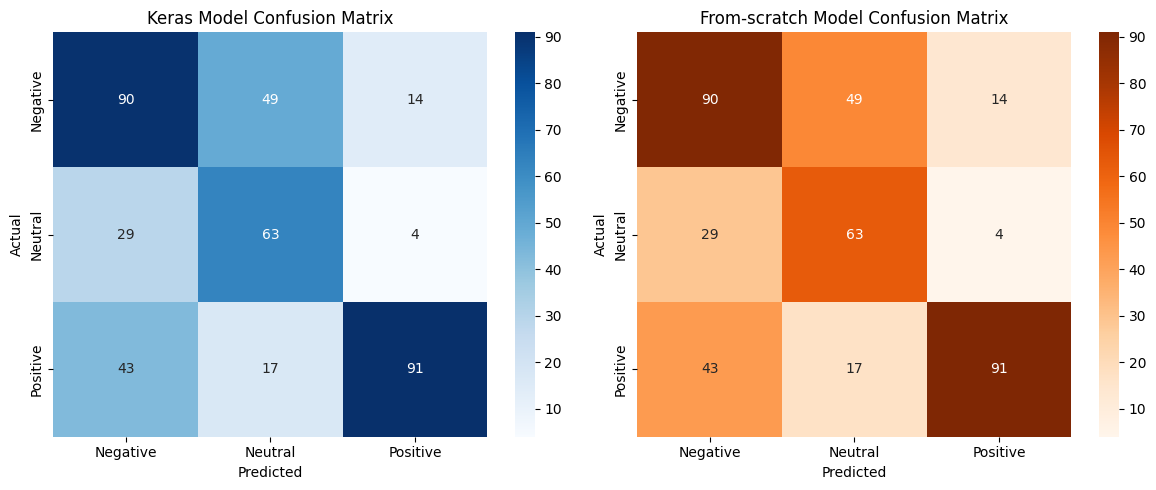

In [206]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

try:
    # Keras confusion matrix
    cm_keras = confusion_matrix(y_test_np, keras_pred_full)
    sns.heatmap(cm_keras, annot=True, fmt='d', cmap='Blues', ax=axes[0],
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'])
    axes[0].set_title('Keras Model Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
except Exception as e:
    print(f"Error creating Keras confusion matrix: {e}")
    keras_pred_fallback = np.argmax(final_model.predict(X_test_vec, verbose=0), axis=1)
    cm_keras = confusion_matrix(y_test_np, keras_pred_fallback)
    sns.heatmap(cm_keras, annot=True, fmt='d', cmap='Blues', ax=axes[0],
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'])
    axes[0].set_title('Keras Model Confusion Matrix (Final)')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

try:
    # From-scratch confusion matrix
    cm_scratch = confusion_matrix(y_test_np, scratch_pred_full)
    sns.heatmap(cm_scratch, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'])
    axes[1].set_title('From-scratch Model Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
except Exception as e:
    print(f"Error creating from-scratch confusion matrix: {e}")
    cm_scratch = confusion_matrix(y_test_np, scratch_preds_argmax)
    sns.heatmap(cm_scratch, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'])
    axes[1].set_title('From-scratch Model Confusion Matrix (Trained)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 6. Batch Inference Testing (Bonus Feature)

In [210]:
print("\n=== TESTING BATCH INFERENCE (BONUS) ===")

# Test different batch sizes
batch_sizes = [1, 8, 16, 32, 64]
test_sample = X_test_vec[:100] 

print("Testing batch inference dengan berbagai ukuran batch:")
print(f"{'Batch Size':<12} {'Predictions Shape':<20} {'Time (s)':<10}")
print("-" * 50)

import time

# Test with the loaded scratch model
test_model = rnn_scratch if 'rnn_scratch' in locals() else rnn_scratch

for batch_size in batch_sizes:
    start_time = time.time()
    
    try:
        # Test batch prediction
        predictions = test_model.predict(test_sample, batch_size=batch_size)
        end_time = time.time()
        inference_time = end_time - start_time
        
        print(f"{batch_size:<12} {str(predictions.shape):<20} {inference_time:<10.4f}")
    except Exception as e:
        print(f"{batch_size:<12} {'Error':<20} {str(e)[:20]}")

print("\n✓ Batch inference testing completed!")

print("\n=== BATCH INFERENCE DEMONSTRATION ===")
print("Demonstrating different batch sizes with timing...")

demo_samples = [10, 50, 100, 200]
for n_samples in demo_samples:
    if n_samples <= len(X_test_vec):
        sample_data = X_test_vec[:n_samples]
        
        start_time = time.time()
        predictions = test_model.predict(sample_data, batch_size=32)
        end_time = time.time()

        predictions = np.argmax(predictions, axis=1)
        print(f"\nBatch size: {n_samples}")
        print(f"Output shape: {predictions.shape}")
        print(f"f1_score: {f1_score(y_test_np[:n_samples], predictions, average='macro', zero_division=0):.4f}")
        print(f"Time taken: {end_time - start_time:.4f} seconds")
        n_samples = len(sample_data)
        if n_samples > 0:
            print(f"Sampled {n_samples} samples.")
        else:
            print("No samples to predict.")


=== TESTING BATCH INFERENCE (BONUS) ===
Testing batch inference dengan berbagai ukuran batch:
Batch Size   Predictions Shape    Time (s)  
--------------------------------------------------
1            (100, 3)             5.3009    
8            (100, 3)             1.0999    
16           (100, 3)             0.8957    
32           (100, 3)             0.7405    
64           (100, 3)             0.6881    

✓ Batch inference testing completed!

=== BATCH INFERENCE DEMONSTRATION ===
Demonstrating different batch sizes with timing...

Batch size: 10
Output shape: (10,)
f1_score: 0.3926
Time taken: 0.0760 seconds
Sampled 10 samples.

Batch size: 50
Output shape: (50,)
f1_score: 0.5790
Time taken: 0.3282 seconds
Sampled 50 samples.

Batch size: 100
Output shape: (100,)
f1_score: 0.5712
Time taken: 0.7601 seconds
Sampled 100 samples.

Batch size: 200
Output shape: (200,)
f1_score: 0.5748
Time taken: 1.4281 seconds
Sampled 200 samples.
